# 1. Preparação do notebook

In [10]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [11]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [12]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Heterocedasticity] Geração de séries temporais.xlsx to [BM Heterocedasticity] Geração de séries temporais (1).xlsx


,bm_heteroscedasticity_1,bm_heteroscedasticity_2,bm_heteroscedasticity_3,bm_heteroscedasticity_4,bm_heteroscedasticity_5,bm_heteroscedasticity_6,bm_heteroscedasticity_7,bm_heteroscedasticity_8,bm_heteroscedasticity_9,bm_heteroscedasticity_10
0,0.496714,-1.544434,-0.120643,-0.160665,0.269824,-1.153504,-1.239162,1.178275,-2.678408,-0.496440
1,0.358357,-1.051218,-0.470764,-1.545975,0.577584,-302.123778,-0.102988,0.852262,-1.671607,0.696883
2,1.006917,-0.216493,-0.651815,273.603212,-0.181961,0.326851,0.237425,191.234731,-1.406661,0.361209
3,2.533023,-0.818833,-1.367922,-1.852257,0.878579,0.386145,-0.179616,190.550507,-1.583443,-0.212217
4,2.298239,0.350223,-1.728802,-3.088030,0.435163,-1.599820,-1.725778,0.879891,-3.254722,0.069842


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [13]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [14]:
# Seleção da série
series = df['bm_heteroscedasticity_1'].values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [15]:
X

array([[   0.49671415],
       [   0.35835678],
       [   1.00691733],
       ...,
       [-337.97491953],
       [-344.57753295],
       [-340.72104326]])

In [16]:
y

array([   0.35835678,    1.00691733,    2.53302298, ..., -344.57753295,
       -340.72104326, -340.71549354])

## 3.2. Normalização

In [17]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [18]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [19]:
# Função para treinar KNN com otimização de hiperparâmetros
def train_knn(X_train, y_train):
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11]}
    model = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train)
    return model.best_estimator_

In [20]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo ELM
knn_model = train_knn(X_train, y_train)

## 3.3. Avaliação do modelo

In [21]:
# Previsões no conjunto de treino
y_train_pred_scaled = knn_model.predict(X_train).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Previsões no conjunto de teste
y_test_pred_scaled = knn_model.predict(X_test).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [22]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values).round(2)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values).round(2)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 30.80%
sMAPE Teste: 167.10%


In [23]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 57.07
RMSE Teste: 232.24


In [24]:
# Cálculo do Huber Loss
def huber_loss(actual, predicted, delta=1.0):
    error = predicted - actual
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss_train = huber_loss(train_results['Actual'].values, train_results['Predicted'].values)
huber_loss_test = huber_loss(test_results['Actual'].values, test_results['Predicted'].values)

print(f'Huber Loss Treino: {huber_loss_train:.2f}')
print(f'Huber Loss Teste: {huber_loss_test:.2f}')

Huber Loss Treino: 22.04
Huber Loss Teste: 198.64


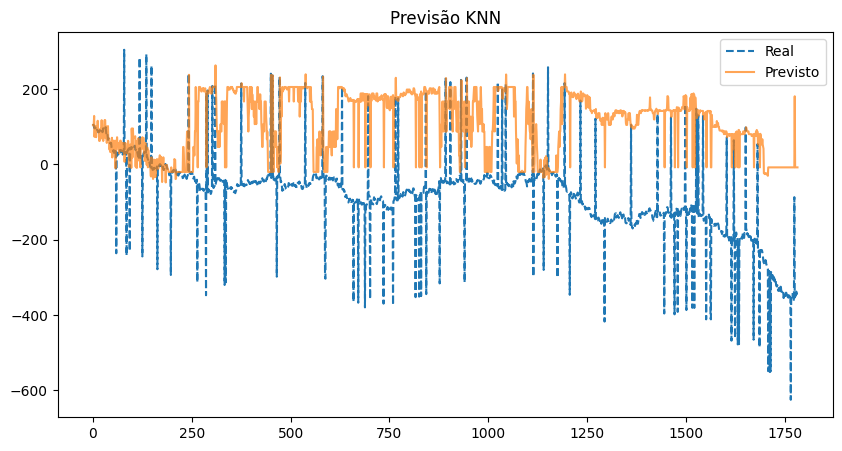

In [25]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
plt.title(f'Previsão KNN')
plt.show()

# 4. Análise dos erros

In [26]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
1709,426.963400,178.959197,248.004203
1734,429.669911,189.440359,240.229552
1738,430.843762,184.235901,246.607861
1754,431.518116,184.908188,246.609928
1764,439.173501,195.669800,243.503701
...,...,...,...
1778,-349.127908,-8.057587,-341.070320
1779,-337.974920,-8.057587,-329.917332
1780,-344.577533,-8.057587,-336.519946
1781,-340.721043,-8.057587,-332.663456


In [27]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,0.358357,-24.146807,24.505164,False
1,1.006917,-23.866512,24.873429,False
2,2.533023,-48.044423,50.577446,False
3,2.298239,3.187921,-0.889682,False
4,2.063314,1.712944,0.350370,False


In [28]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 196166.0
Valor-p: 1.0
Não há evidência suficiente para afirmar que os outliers causam maiores erros.


In [29]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 371.8937348374675
Valor-p: 1.7550987335772227e-81
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [30]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: -0.11889275367389501
Valor-p: 3.73338395658728e-20
Existe uma relação significativa entre outliers e a magnitude do erro.
